## Topic - Stroke Prediction

### Author - Era Ebhodaghe

In [6]:
#importing libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier


from sklearn.model_selection import train_test_split #split
from sklearn.metrics import accuracy_score #metrics

#tools for hyperparameters search
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [7]:
#loading dataset
df = pd.read_csv('/Users/valuedcustomer/Documents/Bellvue/DSC 630 - Predictive Analytics/healthcare-dataset-stroke-data.csv')
df.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,5110.0,36517.829354,21161.721625,67.00,17741.250,36932.000,54682.00,72940.00
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.500,28.100,33.10,97.60
stroke,5110.0,0.048728,0.215320,0.00,0.000,0.000,0.00,1.00


## Data Exploration

#### Plot 1: Age Distribution

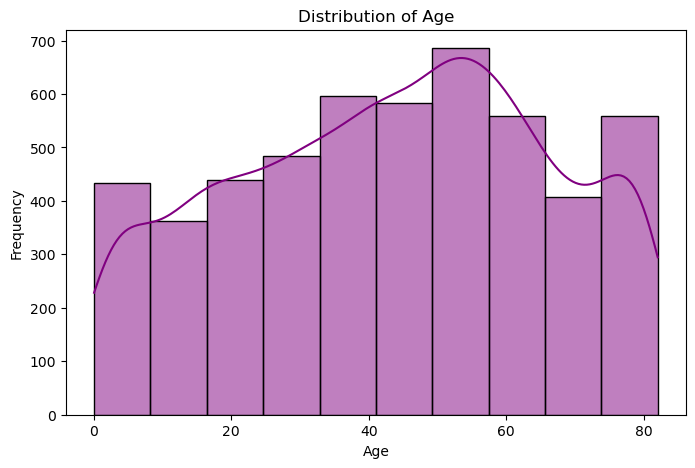

In [11]:
plt.figure(figsize=(8, 5))
sns.histplot(df['age'], bins=10, kde=True, color='purple')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


#### Plot 2 : Gender Distribution

Text(0, 0.5, 'Count')

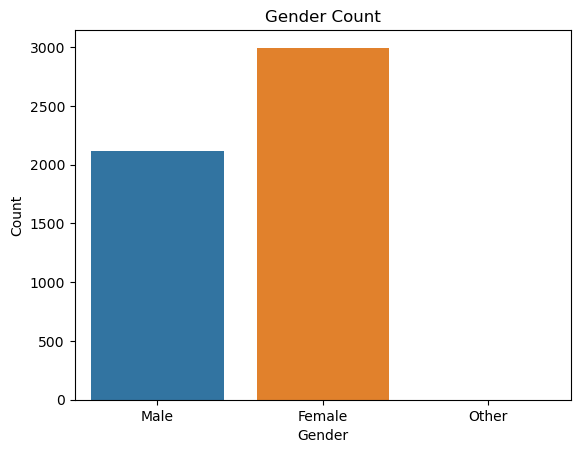

In [13]:
sns.countplot(data = df, x = 'gender', hue = 'gender')
plt.title('Gender Count')
plt.xlabel('Gender')
plt.ylabel('Count')

In [14]:
df['stroke'].value_counts()

stroke
0    4861
1     249
Name: count, dtype: int64

In [15]:
# number of rows in dataset

print("Dataset consists of {rows} rows.".format(rows = len(df)))

Dataset consists of 5110 rows.


In [16]:
#find percentage of missing values for each column
missing_values = df.isnull().mean()*100

missing_values.sum()

3.9334637964774952

In [17]:
#remove null values
df.dropna(inplace=True)

### Exploring Categorical Columns

In [19]:
df.select_dtypes(include=['object']).columns.tolist()

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [20]:
df.columns = df.columns.to_series().apply(lambda x: x.strip())

#### Plot to explore categorical columns

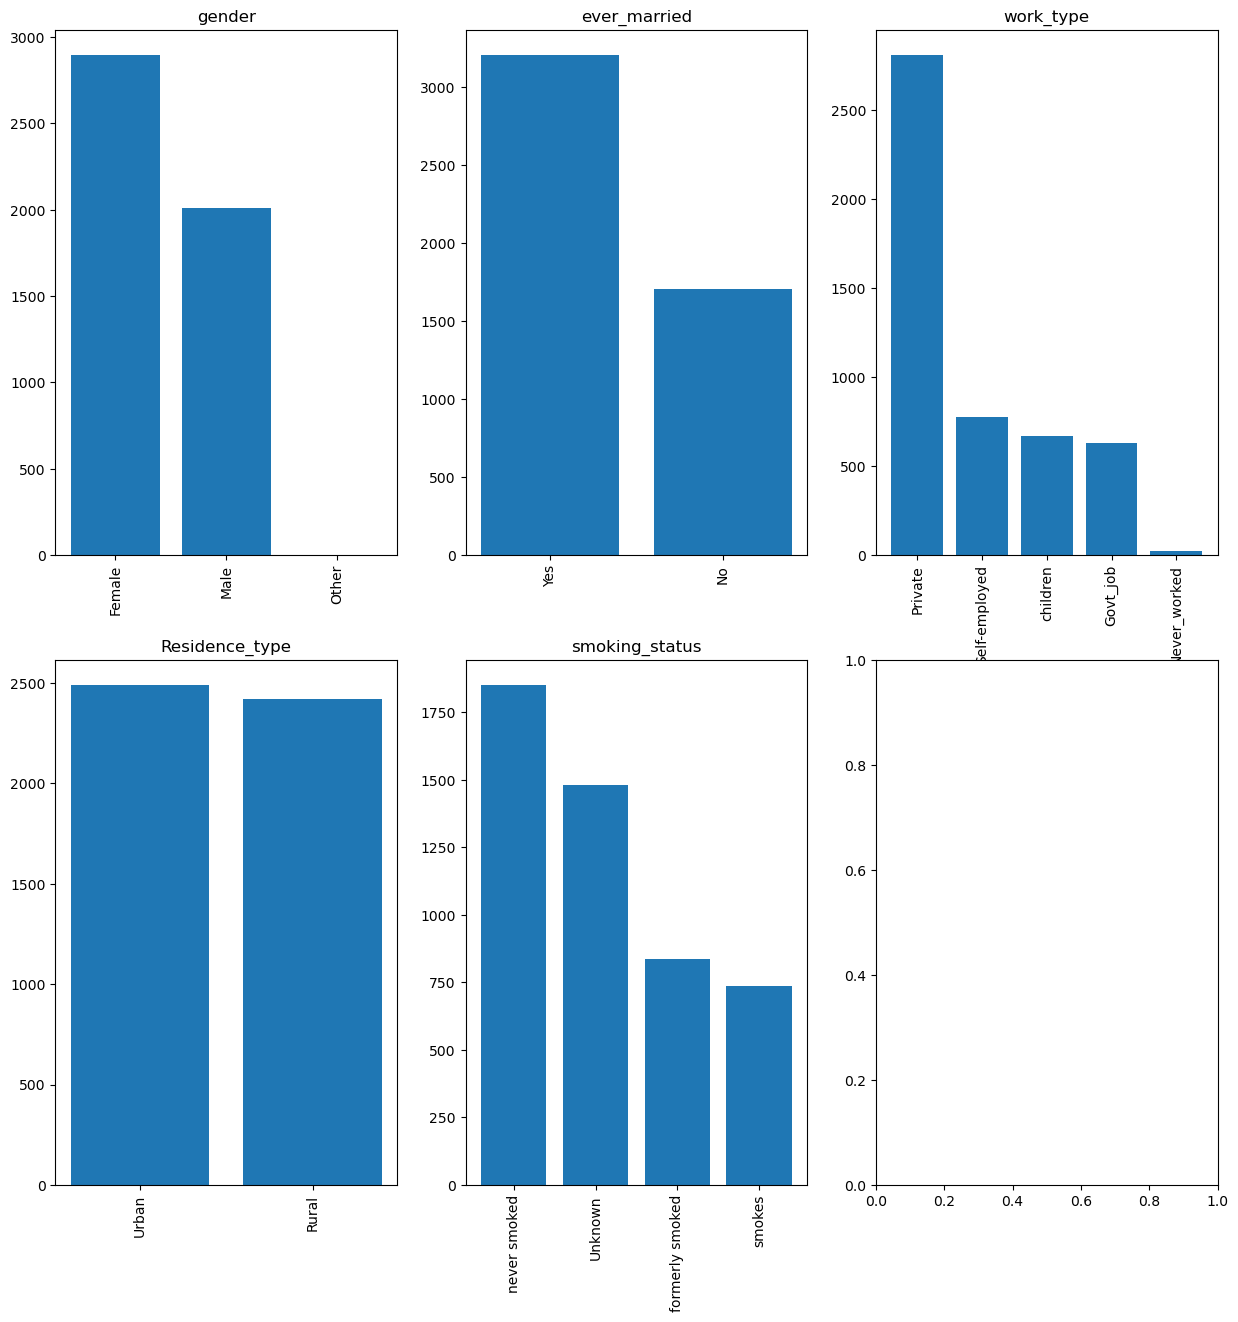

In [22]:
cat_columns = ['gender','ever_married','work_type','Residence_type', 'smoking_status']

fig, axs = plt.subplots(2,3, sharex=False, sharey=False, figsize=(15, 15))

counter = 0
for cat_column in cat_columns:
    value_counts = df[cat_column].value_counts()
    
    trace_x = counter // 3
    trace_y = counter % 3
    x_pos = np.arange(0, len(value_counts))
    
    axs[trace_x, trace_y].bar(x_pos, value_counts.values, tick_label = value_counts.index)
    
    axs[trace_x, trace_y].set_title(cat_column)
    
    for tick in axs[trace_x, trace_y].get_xticklabels():
        tick.set_rotation(90)
    
    counter += 1

plt.show()

### Exploring Numerical Columns

In [24]:
df.select_dtypes(exclude=['object']).columns.tolist()

['id',
 'age',
 'hypertension',
 'heart_disease',
 'avg_glucose_level',
 'bmi',
 'stroke']

#### Dropping Unwanted Column

In [26]:
df = df.drop(['id'],axis=1)

#### Plotting histograms to explore the numerical column values

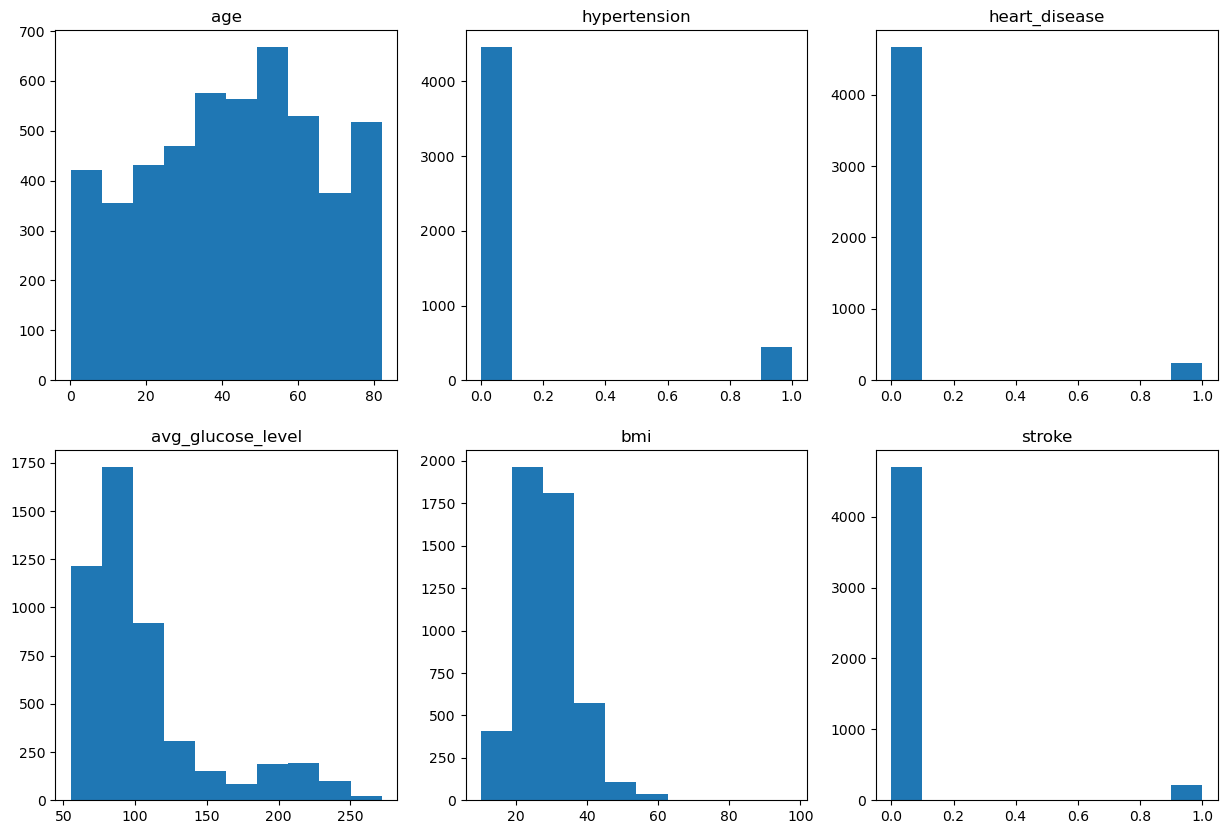

In [28]:
num_columns = ['age','hypertension', 'heart_disease', 'avg_glucose_level','bmi','stroke']

fig, axs = plt.subplots(2, 3, sharex=False, sharey=False, figsize=(15, 10))

counter = 0
for num_column in num_columns:
    
    trace_x = counter // 3
    trace_y = counter % 3
    
    axs[trace_x, trace_y].hist(df[num_column])
    
    axs[trace_x, trace_y].set_title(num_column)
    
    counter += 1

plt.show()

### Analyzing Stroke Column

<Axes: title={'center': 'Stroke'}, xlabel='stroke'>

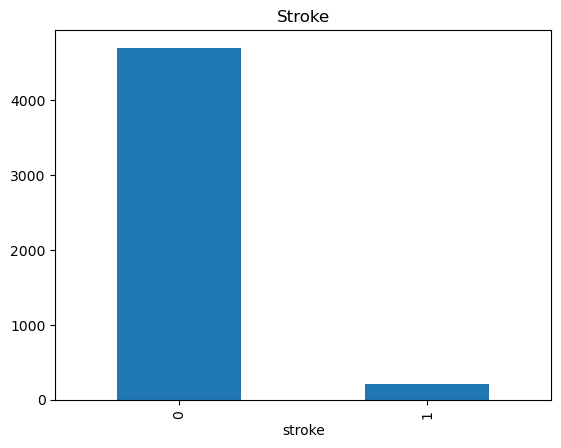

In [30]:
value_counts = df['stroke'].value_counts()

value_counts.plot.bar(title = 'Stroke')

#### Before we will be able to apply machine learning techniques, we should prepare the dataset for processing:

#### 1. Convert columns with 'yes' and 'no' values to boolean columns;
#### 2. Convert categorical columns into dummy variables.

In [32]:
#using label encoder to change features to numerical values
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for column in df.columns:
    df[column] = le.fit_transform(df[column])

## Data Processing

#### Splitting data into training and test set

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Defining features and target
X = df.drop(columns=['stroke'])
y = df['stroke']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Handling Class Imbalance

In [37]:
from imblearn.over_sampling import SMOTE

# Applying SMOTE only on the training set
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

In [38]:
from collections import Counter
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_balanced))

Before SMOTE: Counter({0: 3760, 1: 167})
After SMOTE: Counter({0: 3760, 1: 3760})


### Training Model

In [40]:
from sklearn.feature_selection import SelectKBest, f_classif

# Selecting top k features based on ANOVA F-statistics
selector = SelectKBest(score_func=f_classif, k=8) 
X_train_selected = selector.fit_transform(X_train_balanced, y_train_balanced)
X_test_selected = selector.transform(X_test_scaled)

# Checking which features were selected
mask = selector.get_support()
selected_features = X.columns[mask]
print("Selected features:", selected_features.tolist())

Selected features: ['age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'avg_glucose_level', 'bmi', 'smoking_status']


In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

# Logistic Regression
model_lr = LogisticRegression(class_weight='balanced', random_state=42)
model_lr.fit(X_train_selected, y_train_balanced)

# Random Forest
model_rf = RandomForestClassifier(class_weight='balanced', random_state=42)
model_rf.fit(X_train_selected, y_train_balanced)

# Gradient Boosting
model_gb = GradientBoostingClassifier(random_state=42)
model_gb.fit(X_train_selected, y_train_balanced)

# Decision Tree
model_dt = DecisionTreeClassifier(class_weight='balanced', max_depth=4, random_state=42)
model_dt.fit(X_train_selected, y_train_balanced)

DecisionTreeClassifier(class_weight='balanced', max_depth=4, random_state=42)

### Model Evaluation

In [43]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, confusion_matrix, classification_report
)

def evaluate_model(model, name):
    y_pred = model.predict(X_test_selected)
    y_proba = model.predict_proba(X_test_selected)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    print(f"\n=== Classification Report for {name} ===")
    print(classification_report(y_test, y_pred, digits=3))

    model_results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'ROC AUC': roc,
        'True Positives': tp,
        'False Negatives': fn
    })

model_results = []
evaluate_model(model_lr, "Logistic Regression")
evaluate_model(model_rf, "Random Forest")
evaluate_model(model_gb, "Gradient Boosting")
evaluate_model(model_dt, "Decision Tree")


=== Classification Report for Logistic Regression ===
              precision    recall  f1-score   support

           0      0.980     0.766     0.860       940
           1      0.109     0.643     0.187        42

    accuracy                          0.761       982
   macro avg      0.544     0.704     0.523       982
weighted avg      0.942     0.761     0.831       982


=== Classification Report for Random Forest ===
              precision    recall  f1-score   support

           0      0.961     0.950     0.956       940
           1      0.113     0.143     0.126        42

    accuracy                          0.915       982
   macro avg      0.537     0.546     0.541       982
weighted avg      0.925     0.915     0.920       982


=== Classification Report for Gradient Boosting ===
              precision    recall  f1-score   support

           0      0.969     0.926     0.947       940
           1      0.167     0.333     0.222        42

    accuracy             

In [44]:
# Summarize results
results_df = pd.DataFrame(model_results)

performance_metrics = results_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']]
error_analysis = results_df[['Model', 'True Positives', 'False Negatives']]

print("\n=== Model Performance Metrics ===\n")
print(performance_metrics.round(3).to_string(index=False))

print("\n=== Error Analysis by Model ===\n")
print(error_analysis.to_string(index=False))


=== Model Performance Metrics ===

              Model  Accuracy  Precision  Recall  F1-Score  ROC AUC
Logistic Regression     0.761      0.109   0.643     0.187    0.812
      Random Forest     0.915      0.113   0.143     0.126    0.770
  Gradient Boosting     0.900      0.167   0.333     0.222    0.762
      Decision Tree     0.784      0.110   0.571     0.185    0.786

=== Error Analysis by Model ===

              Model  True Positives  False Negatives
Logistic Regression              27               15
      Random Forest               6               36
  Gradient Boosting              14               28
      Decision Tree              24               18


### Analyzing Recall and ROC-AUC

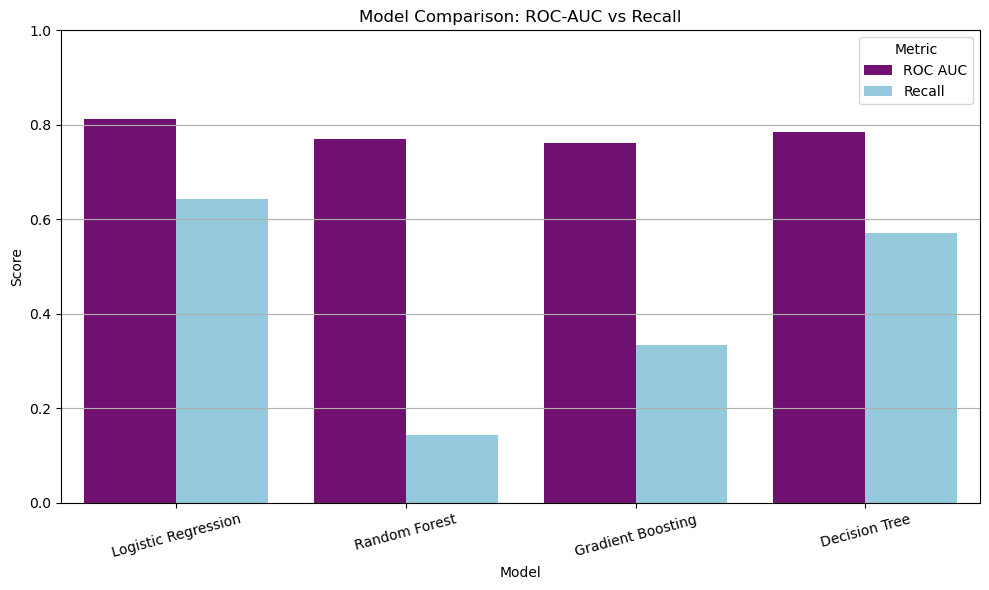

In [46]:
import seaborn as sns
# Reshaping the DataFrame
melted = results_df.melt(id_vars='Model', value_vars=['ROC AUC', 'Recall'], 
                         var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x='Model', y='Score', hue='Metric', palette=['purple', 'skyblue'])
plt.title('Model Comparison: ROC-AUC vs Recall')
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

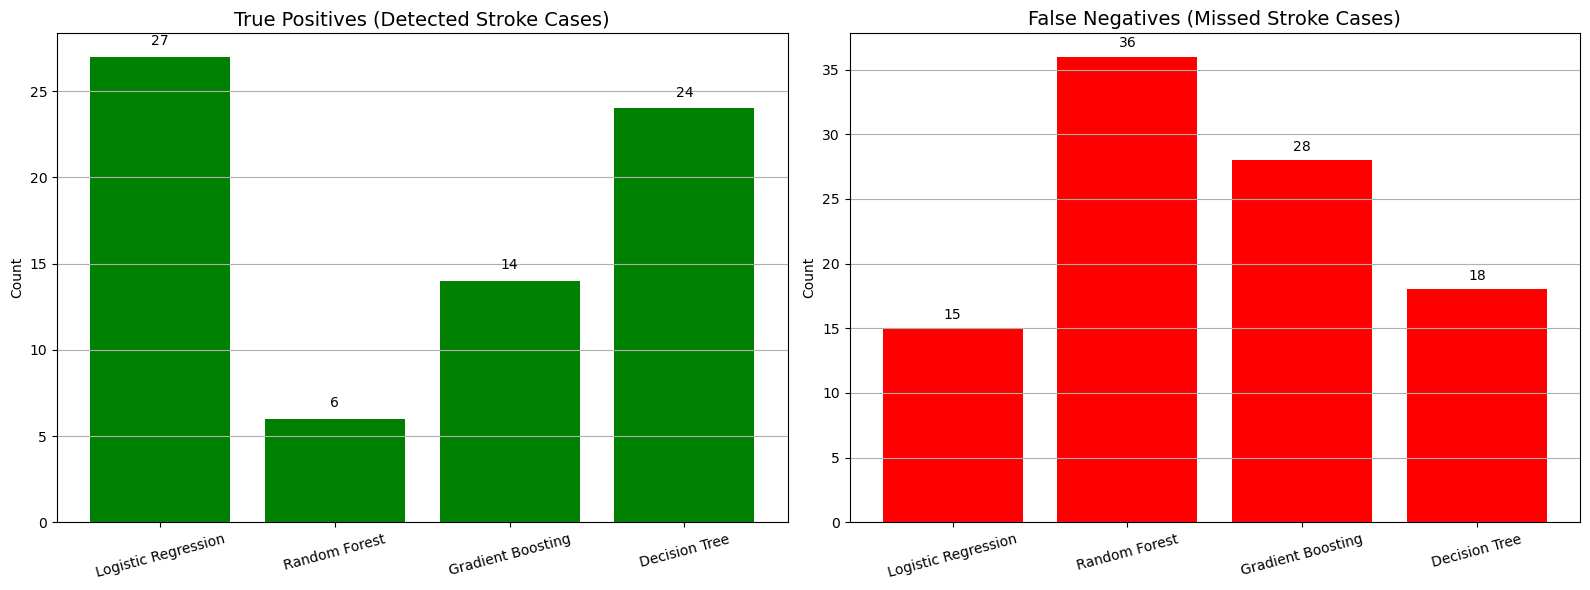

In [47]:
models = results_df['Model']
tp_values = results_df['True Positives']
fn_values = results_df['False Negatives']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# True Positives Plot 
axes[0].bar(models, tp_values, color='green')
axes[0].set_title('True Positives (Detected Stroke Cases)', fontsize=14)
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=15)
axes[0].grid(axis='y')

# Annotating TP values
for i, val in enumerate(tp_values):
    axes[0].text(i, val + 0.5, str(val), ha='center', va='bottom', fontsize=10)

# False Negatives Plot
axes[1].bar(models, fn_values, color='red')
axes[1].set_title('False Negatives (Missed Stroke Cases)', fontsize=14)
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=15)
axes[1].grid(axis='y')

# Annotating FN values
for i, val in enumerate(fn_values):
    axes[1].text(i, val + 0.5, str(val), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

#### Finding the best 5 features

In [49]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Apply chi-square statistic selector to pick the five best features
selector = SelectKBest(chi2, k=5)
X_train_select= selector.fit_transform(X_train, y_train)

# Get the selected feature names
selected_feature_names = X.columns[selector.get_support()]
df_fn = pd.DataFrame(selected_feature_names)
print('The best five features are:', df_fn)


The best five features are:                    0
0                age
1       hypertension
2      heart_disease
3  avg_glucose_level
4                bmi


### Hyperparameter Tuning

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)
import pandas as pd
import matplotlib.pyplot as plt

# Grid search for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['liblinear']
}

grid_search = GridSearchCV(
    LogisticRegression(class_weight='balanced', max_iter=1000),
    param_grid, cv=5, scoring='recall', n_jobs=-1
)
grid_search.fit(X_train_selected, y_train_balanced)
best_lr_model = grid_search.best_estimator_

# Evaluation
y_pred = best_lr_model.predict(X_test_selected)
y_proba = best_lr_model.predict_proba(X_test_selected)[:, 1]

metrics = {
    'Model': 'Logistic Regression',
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_proba),
    'True Positives': confusion_matrix(y_test, y_pred)[1, 1],
    'False Negatives': confusion_matrix(y_test, y_pred)[1, 0]
}

results_df = pd.DataFrame([metrics])

# Display results
print("=== Model Performance Metrics ===\n")
print(results_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']].round(3).to_string(index=False))

=== Model Performance Metrics ===

              Model  Accuracy  Precision  Recall  F1-Score  ROC AUC
Logistic Regression     0.749      0.114   0.714     0.196    0.809


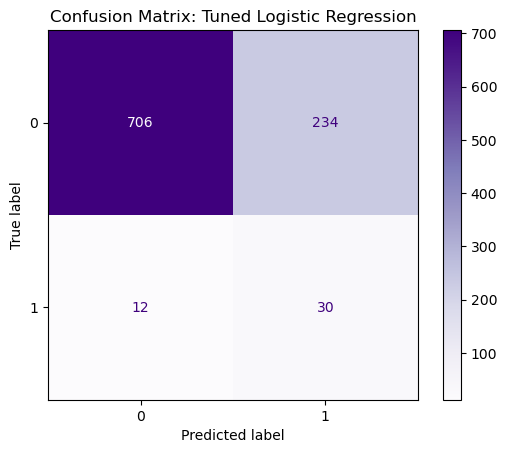

In [52]:
# Plotting confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Purples')
plt.title("Confusion Matrix: Tuned Logistic Regression")
plt.show()